In [2]:
!python -V

Python 3.10.4


In [3]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [4]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={'data-scientist': 'soumyadip', 'model': 'xgboost'}>

In [5]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

df[categorical] = df[categorical].astype(str)

In [6]:
train_dicts = df[categorical + numerical].to_dict(orient="records")

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [8]:
y_pred = lr.predict(X_train)

In [9]:
mean_squared_error(y_train, y_pred, squared=False)

9.838799799829626

c:\Users\soumy\anaconda3\envs\mlops\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\soumy\anaconda3\envs\mlops\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


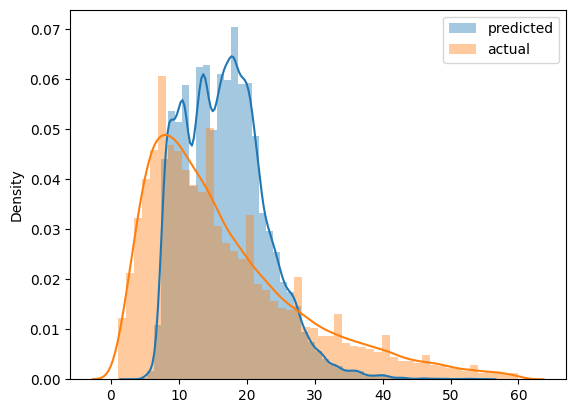

In [11]:
sns.distplot(y_pred, label="predicted")
sns.distplot(y_train, label="actual")
plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)
        
        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
        
    elif filename.endswith(".parquet"):
        df = pd.read_parquet(filename)
        
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)
    
    return df


In [11]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [14]:
len(df_train), len(df_val)

(73908, 61921)

In [12]:
df_train["PO_DO"] = df_train['PULocationID'] + "_" + df_train["DOLocationID"]
df_val["PO_DO"] = df_val['PULocationID'] + "_" + df_val["DOLocationID"]

In [13]:
categorical = ["PO_DO"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)


In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715209549528

In [19]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [20]:
with mlflow.start_run():
    
    mlflow.set_tag("data-scientist", "soumyadip")
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.12 
    mlflow.log_param("alpha",alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

In [15]:
import xgboost as xgb

In [16]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [17]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [24]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [25]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[00:21:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:6.93017                           
[1]	validation-rmse:6.74825                           
[2]	validation-rmse:6.72472                           
[3]	validation-rmse:6.71751                           
[4]	validation-rmse:6.71002                           
[5]	validation-rmse:6.70278                           
[6]	validation-rmse:6.69954                           
[7]	validation-rmse:6.69519                           
[8]	validation-rmse:6.69406                           
[9]	validation-rmse:6.69044                           
[10]	validation-rmse:6.68702                          
[11]	validation-rmse:6.68635                          
[12]	validation-rmse:6.68458                          
[13]	validation-rmse:6.68447                          
[14]	validation-rmse:6.68172                         

In [ ]:
mlflow.xgboost.autolog()

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

best_params = {
        'learning_rate': 0.6383041146845452,
        'max_depth': 31,
        'min_child_weight': 1.1819369158769895,
        'objective': 'reg:linear',
        'reg_alpha': 0.14202144046856877,
        'reg_lambda': 0.18611039063872484,
        'seed': 42
    }

booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )